# Project SpaceJam

- Data Loading
- Model
- Training + Discussion
- Test + Discussion
- Test suite (load pretrained, test dataset)

## Import

In [1]:
SEED = 9126

import os
import json
import time
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import cv2

from PIL import Image
import pandas as pd
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import Video

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

transform= torchvision.transforms.ToTensor()

USE_CUDA = True
CUDA = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")

if CUDA:
    print('run on %s' % device)

run on cuda


## Caricamento dei dizionari

In [2]:
DATASET_DIR = 'dataset'
DATASET_FILES = 'dataset/examples'
KEYSET_FILE = 'testset_keys_1lug2020.txt'

labels_dict = {0 : "block", 1 : "pass", 2 : "run", 3: "dribble",4: "shoot",
          5 : "ball in hand", 6 : "defense", 7: "pick" , 8 : "no_action" , 
          9: "walk"}

with open(os.path.join(DATASET_DIR, 'annotation_dict.json')) as fp:
    annotations = json.load(fp)    

In [3]:
with open(KEYSET_FILE) as fp:
    keys_test = json.load(fp)

annotationTrain = dict(filter(lambda x: x[0] not in keys_test, annotations.items()))
annotationTest = dict(filter(lambda x: x[0] in keys_test, annotations.items()))

len(annotations), len(annotationTrain), len(annotationTest)

(37085, 25959, 11126)

## Funzioni di utilità e prime prove

In [4]:
Video(os.path.join(DATASET_FILES, '0000000.mp4'))

In [5]:
def load_video(path):
    framesDelVideo = []
    
    video = cv2.VideoCapture(path)
    while True:
        # Capture frame-by-frame
        ret, frame = video.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            frame = transform(Image.fromarray(frame))
            framesDelVideo.append(frame.unsqueeze(0))
        else:
            break

    return torch.cat(framesDelVideo, axis=0)


Funzione per stampare tutti i frame del video concatenati

In [6]:
def print_video(image):
    image = image.numpy().transpose(0,2,3,1)
    video = np.concatenate([np.concatenate([image[i+j] for j in range(4)],axis=1) for i in range (0,16,4)],axis=0)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.axis('off')
    ax.imshow(video, interpolation='nearest')

Stampa del video con resize

In [7]:
def print_video_resized(image,scale_percent):
    image = image.numpy().transpose(0,2,3,1)
    ritorna=[]
    for img in image:
        width = int(img.shape[1] * scale_percent / 100)
        height = int(img.shape[0] * scale_percent / 100)
        dim = (width, height)
        # resize image
        ritorna.append(cv2.resize(img, dim, interpolation = cv2.INTER_AREA))
    
    video = np.concatenate([np.concatenate([ritorna[i+j] for j in range(4)],axis=1) for i in range (0,16,4)],axis=0)

    fig, ax = plt.subplots(figsize=(8,8))
    ax.axis('off')
    ax.imshow(video, interpolation='nearest')

Stampa del video in grayscale con resize

In [8]:
def print_video_resized_gray(image,scale_percent):
    image = image.numpy().transpose(0,2,3,1)
    ritorna=[]
    for img in image:
        width = int(img.shape[1] * scale_percent / 100)
        height = int(img.shape[0] * scale_percent / 100)
        dim = (width, height)
        # resize image
        ritorna.append(cv2.cvtColor(cv2.resize(img, dim, interpolation = cv2.INTER_AREA), cv2.COLOR_BGR2GRAY))
    
    video = np.concatenate([np.concatenate([ritorna[i+j] for j in range(4)],axis=1) for i in range (0,16,4)],axis=0)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.axis('off')
    ax.imshow(video, interpolation='nearest',cmap='gray')


Stampe concatenate:
- Video originale
- Video con resize
- video con resize e in grayscale

torch.Size([16, 3, 176, 128])


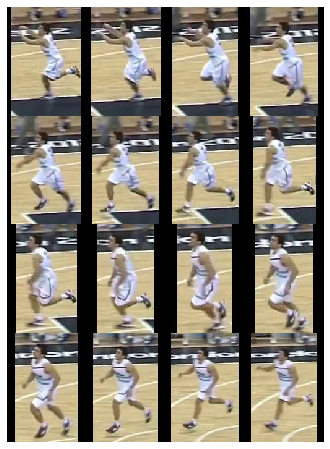

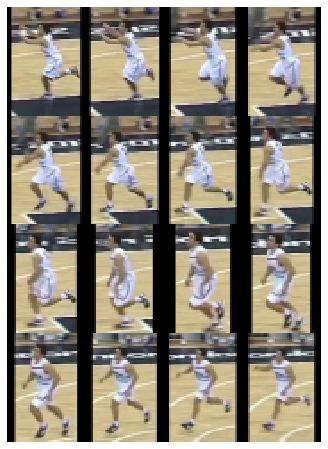

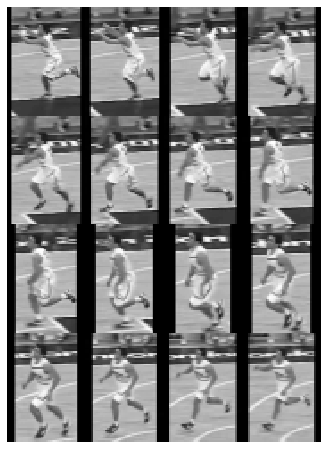

In [9]:
video = load_video(os.path.join(DATASET_FILES, '0000000.mp4'))
print(video.shape)
print_video(video)
print_video_resized(video,35)
print_video_resized_gray(video,35)

Considerazioni:
Al fine di velocizzare l'addestramento del modello, sono state fatte delle prove di downsize e grayscale sui video in modo da ridurre la taglia dell'input senza, però, perdere troppe informazioni. È stato osservato che la scala minima olre la quale non è conveniente scendere è 35%.
Di seguito, si mostra una stampa di un video in scala 25%:

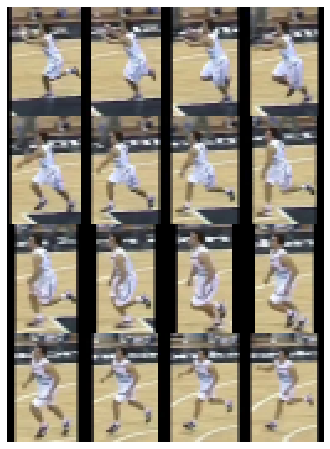

In [10]:
print_video_resized(video,25)

## Preparazione dei dati

Andiamo a preparare le directory con i dataset di train e di test

Creiamo le directory di train e di test

Prepariamo le liste degli id di train e test set

In [11]:
def annotations2idlist(annotations):
    lista = []
    for i in annotations.keys():
        lista.append(i)
    return sorted(lista)
id_train = annotations2idlist(annotationTrain)
id_test = annotations2idlist(annotationTest)

### Definizione dei loader per i dataset
Definiamo i 3 tipi di loader:
- Loader RGB: carica i video nel formato originale
- Loader Grayscale Low Res: carica i video con resize e in grayscale
- Loader Low Res: carica i video con resize

#### Loader RGB

In [12]:
def loader(path):
    framesDelVideo = []
    
    video = cv2.VideoCapture(path)
    while True:
        # Capture frame-by-frame
        ret, frame = video.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            frame = transform(Image.fromarray(frame))
            framesDelVideo.append(frame.unsqueeze(0))
        else:
            break

    return torch.transpose(torch.cat(framesDelVideo, axis=0),0,1)

class Dataset(torch.utils.data.Dataset):
    def __init__(self,root, list_IDs, labels):
        self.labels = labels
        self.list_IDs = list_IDs
        self.root=root

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = loader(os.path.join(self.root,ID+'.mp4'))
        y = self.labels[ID]

        return X, y
    
    
def load_dataset(root,list_IDs,labels):
    dataset = Dataset(root,list_IDs,labels)
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=8,
        num_workers=0,
        shuffle=False
    )
    return loader

train_loader = load_dataset('./dataset/trainingset/examples',id_train,annotationTrain)
test_loader = load_dataset('./dataset/testset/examples',id_test,annotationTest)
pass  

In [13]:
for ids,(data,labels) in enumerate(train_loader):
    print(data.shape)
    break

torch.Size([8, 3, 16, 176, 128])


#### Loader grayscale low-res

In [14]:
scale_percent=35
def gray_loader(path):
    framesDelVideo = []
    
    video = cv2.VideoCapture(path)
    while True:
        # Capture frame-by-frame
        ret, frame = video.read()
        if ret:

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            width = int(frame.shape[1] * scale_percent / 100)
            height = int(frame.shape[0] * scale_percent / 100)
            dim = (width, height)
            frame = cv2.resize(frame,dim,interpolation = cv2.INTER_AREA)
            
            frame = transform(Image.fromarray(frame))
            framesDelVideo.append(frame.unsqueeze(0))
        else:
            break

    return torch.transpose(torch.cat(framesDelVideo, axis=0),0,1)

class gray_dataset(torch.utils.data.Dataset):
    def __init__(self,root, list_IDs, labels):
        self.labels = labels
        self.list_IDs = list_IDs
        self.root=root

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = gray_loader(os.path.join(self.root,ID+'.mp4'))
        y = self.labels[ID]

        return X, y
    
    
def gray_load_dataset(root,list_IDs,labels):
    dataset = gray_dataset(root,list_IDs,labels)
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=8,
        num_workers=0,
        shuffle=False
    )
    return loader
gray_train_loader = gray_load_dataset('./dataset/trainingset/examples',id_train,annotationTrain)
gray_test_loader = gray_load_dataset('./dataset/testset/examples',id_test,annotationTest)

In [15]:
for idx ,(data,labels) in enumerate(gray_train_loader):
    print(data.shape)
    break

torch.Size([8, 1, 16, 61, 44])


#### Loader low res

In [16]:
scale_percent=35
def lr_loader(path):
    framesDelVideo = []
    
    video = cv2.VideoCapture(path)
    while True:
        # Capture frame-by-frame
        ret, frame = video.read()
        if ret:

            width = int(frame.shape[1] * scale_percent / 100)
            height = int(frame.shape[0] * scale_percent / 100)
            dim = (width, height)
            frame = cv2.resize(frame,dim,interpolation = cv2.INTER_AREA)
            
            frame = transform(Image.fromarray(frame))
            framesDelVideo.append(frame.unsqueeze(0))
        else:
            break
            
    return torch.transpose(torch.cat(framesDelVideo, axis=0),0,1)

class lr_dataset(torch.utils.data.Dataset):
    def __init__(self,root, list_IDs, labels):
        self.labels = labels
        self.list_IDs = list_IDs
        self.root=root

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = lr_loader(os.path.join(self.root,ID+'.mp4'))
        y = self.labels[ID]

        return X, y
    
    
def lr_load_dataset(root,list_IDs,labels):
    dataset = lr_dataset(root,list_IDs,labels)
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=8,
        num_workers=0,
        shuffle=False
    )
    return loader
lr_train_loader = lr_load_dataset('./dataset/trainingset/examples',id_train,annotationTrain)
lr_test_loader = lr_load_dataset('./dataset/testset/examples',id_test,annotationTest)

In [17]:
for idx ,(data,labels) in enumerate(lr_train_loader):
    print(data.shape)
    break

torch.Size([8, 3, 16, 61, 44])


# Mini-dataset

Definizione di piccoli sample del dataset per eseguire test rapidi

In [18]:
def mini_annotation2idlist(annotations,n):
    l=[]
    count_dict = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}
    for k,v in annotations.items():
        if count_dict[v]!=n:
            l.append(k)
            count_dict[v]+=1
    return l
n=100
mini_id_train = mini_annotation2idlist(annotationTrain,n)
mini_id_test = mini_annotation2idlist(annotationTest,n/2)

In [19]:
mini_train_loader = load_dataset('./dataset/trainingset/examples',mini_id_train,annotationTrain)
mini_test_loader = load_dataset('./dataset/testset/examples',mini_id_test,annotationTest)

Definizione di questi mini loader anche in grayscale

In [20]:
mini_gray_train_loader = gray_load_dataset('./dataset/trainingset/examples',mini_id_train,annotationTrain)
mini_gray_test_loader = gray_load_dataset('./dataset/testset/examples',mini_id_test,annotationTest)

## I modelli

Viene usata una rete convoluzionale 3D semplice. Le intuizioni dietro questa scelta sono le seguenti:
1. Il modello, lavorando su clip di meno di 2 secondi, non necessita di simulare la memoria (come nelle LSTM).
2. La rete C3D lavora bene su clip che descrivono singole azioni semplici e riesce a processare video brevi (sotto i 2 secondi) in tempo ragionevole
3. È stato possibile utilizzare transfer learning, inizializzando i pesi con valori ottenuti addestrando la stessa rete su un dataset molto più grande (UCF 101), per un numero di epoche considerevole. La rete è stata modificata, adattando i layer FC alla dimensione dei video del dataset Space Jam. Questo ha permesso di trasferire i pesi iniziali solo nei layer convoluzionali.

In [21]:
class C3D(nn.Module):

    def __init__(self, num_classes):
        super(C3D, self).__init__()

        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3a = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv3b = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4a = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv4b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv5a = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv5b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 1, 1))

        self.fc6 = nn.Linear(15360, 7680)
        self.fc7 = nn.Linear(7680, 7680)
        self.fc8 = nn.Linear(7680, num_classes)

        self.dropout = nn.Dropout(p=0.5)

        self.relu = nn.ReLU()


    def forward(self, x):
        
        x = self.relu(self.conv1(x))
        x = self.pool1(x)

        x = self.relu(self.conv2(x))
        x = self.pool2(x)

        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool3(x)

        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        x = self.pool4(x)

        x = self.relu(self.conv5a(x))
        x = self.relu(self.conv5b(x))
        x = self.pool5(x)
        
        x = x.view(-1, 15360)
        x = self.relu(self.fc6(x))
        x = self.dropout(x)
        x = self.relu(self.fc7(x))
        x = self.dropout(x)

        logits = self.fc8(x)
        
        return logits
nome_modello = "C3D"
model = C3D(10).to(device)
C3D(10)

C3D(
  (conv1): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3b): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv4b): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool4): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv5a): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=

Questa è la stessa C3D net adattata per prendere in input video con un solo canale

In [21]:
class gray_C3D(nn.Module):

    def __init__(self, num_classes):
        super(gray_C3D, self).__init__()

        self.conv1 = nn.Conv3d(1, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3a = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv3b = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4a = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv4b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv5a = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv5b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 1, 1))

        self.fc6 = nn.Linear(2048, 7680)
        self.fc7 = nn.Linear(7680, 7680)
        self.fc8 = nn.Linear(7680, num_classes)

        self.dropout = nn.Dropout(p=0.5)

        self.relu = nn.ReLU()


    def forward(self, x):
        
        x = self.relu(self.conv1(x))
        x = self.pool1(x)

        x = self.relu(self.conv2(x))
        x = self.pool2(x)

        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool3(x)

        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        x = self.pool4(x)

        x = self.relu(self.conv5a(x))
        x = self.relu(self.conv5b(x))
        x = self.pool5(x)
        
        x = x.view(-1, 2048)
        x = self.relu(self.fc6(x))
        x = self.dropout(x)
        x = self.relu(self.fc7(x))
        x = self.dropout(x)

        logits = self.fc8(x)
        
        return logits
nome_modello = "gray_C3D"
model = gray_C3D(10).to(device)
gray_C3D(10)

gray_C3D(
  (conv1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3b): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv4b): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool4): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv5a): Conv3d(512, 512, kernel_size=(3, 3, 3), st

Questa è la C3D net originale adattata per video in input con risoluzione più bassa

In [22]:
class lr_C3D(nn.Module):

    def __init__(self, num_classes):
        super(lr_C3D, self).__init__()

        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3a = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv3b = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4a = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv4b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv5a = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv5b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 1, 1))

        self.fc6 = nn.Linear(2048, 7680)
        self.fc7 = nn.Linear(7680, 7680)
        self.fc8 = nn.Linear(7680, num_classes)

        self.dropout = nn.Dropout(p=0.5)

        self.relu = nn.ReLU()


    def forward(self, x):
        
        x = self.relu(self.conv1(x))
        x = self.pool1(x)

        x = self.relu(self.conv2(x))
        x = self.pool2(x)

        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool3(x)

        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        x = self.pool4(x)

        x = self.relu(self.conv5a(x))
        x = self.relu(self.conv5b(x))
        x = self.pool5(x)
        
        x = x.view(-1, 2048)
        x = self.relu(self.fc6(x))
        x = self.dropout(x)
        x = self.relu(self.fc7(x))
        x = self.dropout(x)

        logits = self.fc8(x)
        
        return logits
nome_modello = "lr_C3D"
model = lr_C3D(10).to(device)
lr_C3D(10)

lr_C3D(
  (conv1): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3b): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv4b): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool4): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv5a): Conv3d(512, 512, kernel_size=(3, 3, 3), stri

## Transfer learning

I modelli saranno inizializzati (nei livelli convoluzionali) con i pesi della stessa C3D addestrata sui dataset UCF 101 e HMDB, dal progetto di action recognition con pythorch "[pytorch-video-recognition](https://github.com/jfzhang95/pytorch-video-recognition)".
I pesi fully connected sono stati esclusi dal transfer learning per incompatibilità di taglia dei video in input.

In [27]:
def load_pretrained_weights(model):
    """Initialiaze network."""
    corresp_name = {
                    # Conv1
                    "features.0.weight": "conv1.weight",
                    "features.0.bias": "conv1.bias",
                    # Conv2
                    "features.3.weight": "conv2.weight",
                    "features.3.bias": "conv2.bias",
                    # Conv3a
                    "features.6.weight": "conv3a.weight",
                    "features.6.bias": "conv3a.bias",
                    # Conv3b
                    "features.8.weight": "conv3b.weight",
                    "features.8.bias": "conv3b.bias",
                    # Conv4a
                    "features.11.weight": "conv4a.weight",
                    "features.11.bias": "conv4a.bias",
                    # Conv4b
                    "features.13.weight": "conv4b.weight",
                    "features.13.bias": "conv4b.bias",
                    # Conv5a
                    "features.16.weight": "conv5a.weight",
                    "features.16.bias": "conv5a.bias",
                     # Conv5b
                    "features.18.weight": "conv5b.weight",
                    "features.18.bias": "conv5b.bias",
                    }

    p_dict = torch.load('c3d-pretrained.pth')
    s_dict = model.state_dict()
    for name in p_dict:
        if name not in corresp_name:
            continue
        s_dict[corresp_name[name]] = p_dict[name]
    model.load_state_dict(s_dict)

## Addestramento del modello

Scelta dei parametri

In [22]:
# Numero epoche
num_epochs = 50


#Transfer learning
load_pretrained_weights(model)

# Loss 
error = nn.CrossEntropyLoss()

# Optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# print e test every
test_every = 50
print_every = 50
save_every = 200
pass

Addestramento del modello

In [24]:
def train (model, train_loader,test_loader,optimizer,error, test_every=1, print_every=5,save_every= 10 ,num_epochs=1,resume=False):
    try:
        epoch=0
        count = 0
        loss_list = []
        iteration_list = []
        accuracy_list = []
        if resume:
            checkpoint = torch.load(nome_modello+'.pth')
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            epoch = checkpoint['epoch']
            error = checkpoint['loss']
            count = checkpoint['count']
            loss_list = checkpoint['loss_list']
            iteration_list = checkpoint['iteration_list']
            accuracy_list = checkpoint['accuracy_list']
        model.train()

        for epoch in range(epoch,num_epochs):
            for i, (images, labels) in enumerate(train_loader):
                images, labels = images.to(device),labels.to(device)
                # Clear gradients
                optimizer.zero_grad()
                # Forward propagation
                outputs = model(images)
                # Calculate softmax and ross entropy loss

                loss = error(outputs, labels)
                # Calculating gradients
                loss.backward()
                # Update parameters
                optimizer.step()

                count += 1
                if count % test_every == 0:
                    # Calculate Accuracy         
                    correct = 0
                    total = 0
                    # Iterate through test dataset
                    for idx, (images,labels) in enumerate(test_loader):

                        images, labels = images.to(device),labels.to(device)

                        # Forward propagation
                        outputs = model(images)
                        
                        # Get predictions from the maximum value
                        predicted = torch.max(outputs.data, 1)[1]

                        # Total number of labels
                        total += len(labels)
                        correct += (predicted == labels).sum()

                    accuracy = 100 * correct / float(total)

                    # store loss and iteration
                    loss_list.append(loss.data)
                    iteration_list.append(count)
                    accuracy_list.append(accuracy)
                if count % print_every == 0:
                    # Print Loss
                    print('Epoch: {}\t | Iteration: {}\t | Loss: {:.5f}\t | Accuracy: {:.2f}%'.format(epoch, count, loss.data, accuracy))
                if count % save_every==0:
                   torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': error,
                        'iteration_list':iteration_list,
                        'accuracy_list':accuracy_list,
                        'loss_list':loss_list,
                        'count':count
                        }, nome_modello+'.pth') 
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': error,
            'iteration_list':iteration_list,
            'accuracy_list':accuracy_list,
            'loss_list':loss_list,
            'count':count
            }, nome_modello+'.pth')
    except KeyboardInterrupt:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': error,
            'iteration_list':iteration_list,
            'accuracy_list':accuracy_list,
            'loss_list':loss_list,
            'count':count
            }, nome_modello+'.pth')

## train C3D

In [ ]:
train (model, train_loader,test_loader,optimizer,error, test_every=test_every, print_every=print_every, save_every=save_every , num_epochs=num_epochs)

Epoch: 0	 | Iteration: 50	 | Loss: 1.60815	 | Accuracy: 16.55%
Epoch: 0	 | Iteration: 100	 | Loss: 1.26608	 | Accuracy: 31.02%
Epoch: 0	 | Iteration: 150	 | Loss: 2.08311	 | Accuracy: 17.22%
Epoch: 0	 | Iteration: 200	 | Loss: 1.65948	 | Accuracy: 31.02%
Epoch: 0	 | Iteration: 250	 | Loss: 1.73483	 | Accuracy: 31.02%
Epoch: 0	 | Iteration: 300	 | Loss: 2.10076	 | Accuracy: 16.55%
Epoch: 0	 | Iteration: 350	 | Loss: 1.22236	 | Accuracy: 31.02%
Epoch: 0	 | Iteration: 400	 | Loss: 1.69134	 | Accuracy: 31.02%
Epoch: 0	 | Iteration: 450	 | Loss: 2.10953	 | Accuracy: 31.02%
Epoch: 0	 | Iteration: 500	 | Loss: 1.39917	 | Accuracy: 31.02%
Epoch: 0	 | Iteration: 550	 | Loss: 2.08424	 | Accuracy: 31.02%
Epoch: 0	 | Iteration: 600	 | Loss: 2.12177	 | Accuracy: 31.02%
Epoch: 0	 | Iteration: 650	 | Loss: 1.85055	 | Accuracy: 31.02%
Epoch: 0	 | Iteration: 700	 | Loss: 2.42269	 | Accuracy: 31.02%
Epoch: 0	 | Iteration: 750	 | Loss: 2.16855	 | Accuracy: 31.02%
Epoch: 0	 | Iteration: 800	 | Loss: 1.831

A seguito di una breve prova, la rete nella sua forma originale è stata velocemente esclusa per la sua lentezza nell'addestramento e nell'aumento dei valori di accuracy, dopo aver anche considerato i valori ottenuti nel precedente appello (la rete si fermava su un plateau a 50% di accuracy).

## train Low res C3D

In [ ]:
train (model, lr_train_loader,lr_test_loader,optimizer,error, test_every=test_every, print_every=print_every, save_every=save_every , num_epochs=num_epochs)

Epoch: 0	 | Iteration: 50	 | Loss: 1.59362	 | Accuracy: 16.55%
Epoch: 0	 | Iteration: 100	 | Loss: 1.34554	 | Accuracy: 31.02%
Epoch: 0	 | Iteration: 150	 | Loss: 2.06663	 | Accuracy: 25.52%
Epoch: 0	 | Iteration: 200	 | Loss: 1.71772	 | Accuracy: 24.04%
Epoch: 0	 | Iteration: 250	 | Loss: 1.45818	 | Accuracy: 35.03%
Epoch: 0	 | Iteration: 300	 | Loss: 1.62515	 | Accuracy: 22.13%
Epoch: 0	 | Iteration: 350	 | Loss: 1.15355	 | Accuracy: 31.04%
Epoch: 0	 | Iteration: 400	 | Loss: 1.38946	 | Accuracy: 31.02%
Epoch: 0	 | Iteration: 450	 | Loss: 1.96838	 | Accuracy: 34.86%
Epoch: 0	 | Iteration: 500	 | Loss: 1.36521	 | Accuracy: 31.28%
Epoch: 0	 | Iteration: 550	 | Loss: 1.91744	 | Accuracy: 37.79%
Epoch: 0	 | Iteration: 600	 | Loss: 1.71326	 | Accuracy: 28.25%
Epoch: 0	 | Iteration: 650	 | Loss: 1.61374	 | Accuracy: 33.99%
Epoch: 0	 | Iteration: 700	 | Loss: 2.18047	 | Accuracy: 34.11%
Epoch: 0	 | Iteration: 750	 | Loss: 2.17665	 | Accuracy: 31.63%
Epoch: 0	 | Iteration: 800	 | Loss: 1.502

In [28]:
train (model, lr_train_loader,lr_test_loader,optimizer,error, test_every=test_every, print_every=print_every, save_every=save_every , num_epochs=num_epochs, resume=True)

Epoch: 9	 | Iteration: 30450	 | Loss: 0.75078	 | Accuracy: 61.24%
Epoch: 9	 | Iteration: 30500	 | Loss: 0.25803	 | Accuracy: 56.92%
Epoch: 9	 | Iteration: 30550	 | Loss: 0.36973	 | Accuracy: 66.00%
Epoch: 9	 | Iteration: 30600	 | Loss: 0.19032	 | Accuracy: 67.30%
Epoch: 9	 | Iteration: 30650	 | Loss: 0.06766	 | Accuracy: 68.09%
Epoch: 9	 | Iteration: 30700	 | Loss: 0.04622	 | Accuracy: 66.88%
Epoch: 9	 | Iteration: 30750	 | Loss: 0.24616	 | Accuracy: 62.04%
Epoch: 9	 | Iteration: 30800	 | Loss: 0.33918	 | Accuracy: 65.43%
Epoch: 9	 | Iteration: 30850	 | Loss: 0.28550	 | Accuracy: 63.41%
Epoch: 9	 | Iteration: 30900	 | Loss: 0.65512	 | Accuracy: 65.62%
Epoch: 9	 | Iteration: 30950	 | Loss: 0.56394	 | Accuracy: 65.86%
Epoch: 9	 | Iteration: 31000	 | Loss: 1.91269	 | Accuracy: 59.19%
Epoch: 9	 | Iteration: 31050	 | Loss: 0.55056	 | Accuracy: 65.97%
Epoch: 9	 | Iteration: 31100	 | Loss: 0.84480	 | Accuracy: 66.92%
Epoch: 9	 | Iteration: 31150	 | Loss: 0.53706	 | Accuracy: 62.56%
Epoch: 9	 

In [30]:
train (model, lr_train_loader,lr_test_loader,optimizer,error, test_every=test_every, print_every=print_every, save_every=save_every , num_epochs=num_epochs, resume=True)

Epoch: 14	 | Iteration: 46900	 | Loss: 0.35587	 | Accuracy: 58.47%
Epoch: 14	 | Iteration: 46950	 | Loss: 0.07528	 | Accuracy: 58.67%
Epoch: 14	 | Iteration: 47000	 | Loss: 0.48437	 | Accuracy: 66.11%
Epoch: 14	 | Iteration: 47050	 | Loss: 0.09818	 | Accuracy: 67.11%
Epoch: 14	 | Iteration: 47100	 | Loss: 0.00359	 | Accuracy: 69.12%
Epoch: 14	 | Iteration: 47150	 | Loss: 0.00790	 | Accuracy: 68.07%
Epoch: 14	 | Iteration: 47200	 | Loss: 0.05696	 | Accuracy: 64.17%
Epoch: 14	 | Iteration: 47250	 | Loss: 0.06210	 | Accuracy: 64.88%
Epoch: 14	 | Iteration: 47300	 | Loss: 0.10869	 | Accuracy: 63.56%
Epoch: 14	 | Iteration: 47350	 | Loss: 0.39053	 | Accuracy: 65.66%
Epoch: 14	 | Iteration: 47400	 | Loss: 0.33549	 | Accuracy: 67.19%
Epoch: 14	 | Iteration: 47450	 | Loss: 0.67721	 | Accuracy: 63.40%
Epoch: 14	 | Iteration: 47500	 | Loss: 0.13578	 | Accuracy: 65.95%
Epoch: 14	 | Iteration: 47550	 | Loss: 0.35849	 | Accuracy: 66.83%
Epoch: 14	 | Iteration: 47600	 | Loss: 0.48128	 | Accuracy: 66

In [41]:
train (model, lr_train_loader,lr_test_loader,optimizer,error, test_every=test_every, print_every=print_every, save_every=save_every , num_epochs=num_epochs, resume=True)

Epoch: 20	 | Iteration: 66450	 | Loss: 0.01630	 | Accuracy: 66.11%
Epoch: 20	 | Iteration: 66500	 | Loss: 0.07087	 | Accuracy: 62.19%
Epoch: 20	 | Iteration: 66550	 | Loss: 0.01848	 | Accuracy: 68.34%
Epoch: 20	 | Iteration: 66600	 | Loss: 0.01206	 | Accuracy: 67.28%
Epoch: 20	 | Iteration: 66650	 | Loss: 0.00028	 | Accuracy: 69.20%
Epoch: 20	 | Iteration: 66700	 | Loss: 0.06466	 | Accuracy: 69.83%
Epoch: 20	 | Iteration: 66750	 | Loss: 0.00106	 | Accuracy: 70.65%


Sembra che il modello abbia raggiunto un plateau. Andiamo a modificare i parametri del modello per rendere più dinamica l'ottimizzazione.

In [46]:
checkpoint = torch.load(nome_modello+'.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5,gamma=0.1)  # lr/10 ogni 5 epoche
epoch = checkpoint['epoch']
error = checkpoint['loss']
count = checkpoint['count']
loss_list = checkpoint['loss_list']
iteration_list = checkpoint['iteration_list']
accuracy_list = checkpoint['accuracy_list']


torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict':scheduler.state_dict(),
    'loss': error,
    'iteration_list':iteration_list,
    'accuracy_list':accuracy_list,
    'loss_list':loss_list,
    'count':count
    }, nome_modello+'.pth')


## Training con ottimizzatore dinamico

In [22]:
def do_train (model, train_loader,test_loader,optimizer,scheduler,error, test_every=1, print_every=5,save_every= 10 ,num_epochs=1,resume=False):
    try:
        epoch=0
        count = 0
        loss_list = []
        iteration_list = []
        accuracy_list = []
        if resume:
            checkpoint = torch.load(nome_modello+'.pth')
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            epoch = checkpoint['epoch']
            error = checkpoint['loss']
            count = checkpoint['count']
            loss_list = checkpoint['loss_list']
            iteration_list = checkpoint['iteration_list']
            accuracy_list = checkpoint['accuracy_list']
        model.train()

        for epoch in range(epoch,num_epochs):
            for i, (images, labels) in enumerate(train_loader):
                images, labels = images.to(device),labels.to(device)
                # Clear gradients
                optimizer.zero_grad()
                # Forward propagation
                outputs = model(images)
                # Calculate softmax and ross entropy loss

                loss = error(outputs, labels)
                # Calculating gradients
                loss.backward()
                # Update parameters
                optimizer.step()

                count += 1
                if count % test_every == 0:
                    # Calculate Accuracy         
                    correct = 0
                    total = 0
                    # Iterate through test dataset
                    for idx, (images,labels) in enumerate(test_loader):

                        images, labels = images.to(device),labels.to(device)

                        # Forward propagation
                        outputs = model(images)
                        
                        # Get predictions from the maximum value
                        predicted = torch.max(outputs.data, 1)[1]

                        # Total number of labels
                        total += len(labels)
                        correct += (predicted == labels).sum()

                    accuracy = 100 * correct / float(total)

                    # store loss and iteration
                    loss_list.append(loss.data)
                    iteration_list.append(count)
                    accuracy_list.append(accuracy)
                if count % print_every == 0:
                    # Print Loss
                    print('Epoch: {}\t | Iteration: {}\t | Loss: {:.5f}\t | Accuracy: {:.2f}%'.format(epoch, count, loss.data, accuracy))
                if count % save_every==0:
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict':scheduler.state_dict(),
                        'loss': error,
                        'iteration_list':iteration_list,
                        'accuracy_list':accuracy_list,
                        'loss_list':loss_list,
                        'count':count
                        }, nome_modello+'.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict':scheduler.state_dict(),
            'loss': error,
            'iteration_list':iteration_list,
            'accuracy_list':accuracy_list,
            'loss_list':loss_list,
            'count':count
            }, nome_modello+'.pth')
    except KeyboardInterrupt:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict':scheduler.state_dict(),
            'loss': error,
            'iteration_list':iteration_list,
            'accuracy_list':accuracy_list,
            'loss_list':loss_list,
            'count':count
            }, nome_modello+'.pth')

In [ ]:
do_train (model, lr_train_loader,lr_test_loader,optimizer,scheduler,error, test_every=test_every, print_every=print_every, save_every=save_every , num_epochs=num_epochs, resume=True)

Epoch: 20	 | Iteration: 66850	 | Loss: 0.08046	 | Accuracy: 62.49%
Epoch: 20	 | Iteration: 66900	 | Loss: 0.11216	 | Accuracy: 65.74%
Epoch: 20	 | Iteration: 66950	 | Loss: 0.45374	 | Accuracy: 67.47%
Epoch: 20	 | Iteration: 67000	 | Loss: 0.38308	 | Accuracy: 61.19%
Epoch: 20	 | Iteration: 67050	 | Loss: 0.64507	 | Accuracy: 65.97%
Epoch: 20	 | Iteration: 67100	 | Loss: 0.33246	 | Accuracy: 62.52%
Epoch: 20	 | Iteration: 67150	 | Loss: 0.01246	 | Accuracy: 66.07%
Epoch: 20	 | Iteration: 67200	 | Loss: 0.09441	 | Accuracy: 68.34%
Epoch: 20	 | Iteration: 67250	 | Loss: 0.06827	 | Accuracy: 60.75%
Epoch: 20	 | Iteration: 67300	 | Loss: 0.26612	 | Accuracy: 62.13%
Epoch: 20	 | Iteration: 67350	 | Loss: 0.02470	 | Accuracy: 64.12%
Epoch: 20	 | Iteration: 67400	 | Loss: 1.67768	 | Accuracy: 64.47%
Epoch: 20	 | Iteration: 67450	 | Loss: 0.01702	 | Accuracy: 65.85%
Epoch: 20	 | Iteration: 67500	 | Loss: 0.20067	 | Accuracy: 58.75%
Epoch: 20	 | Iteration: 67550	 | Loss: 0.09878	 | Accuracy: 69

# Training con Freezed layers e ottimizzatore dinamico
Proviamo ora a lanciare una run di lr_C3D, congelando i livelli convoluzionali (sui quali abbiamo applicato il transfer learning) con ottimizzazione dinamica.

In [30]:
def freeze_layers (model):
    # Conv1
    model.conv1.weight.requires_grad=False
    model.conv1.bias.requires_grad=False
    # Conv2
    model.conv2.weight.requires_grad=False
    model.conv2.bias.requires_grad=False
    # Conv3a
    model.conv3a.weight.requires_grad=False
    model.conv3a.bias.requires_grad=False
    # Conv3b
    model.conv3b.weight.requires_grad=False
    model.conv3b.bias.requires_grad=False
    # Conv4a
    model.conv4a.weight.requires_grad=False
    model.conv4a.bias.requires_grad=False
    # Conv4b
    model.conv4b.weight.requires_grad=False
    model.conv4b.bias.requires_grad=False
    # Conv5a
    model.conv5a.weight.requires_grad=False
    model.conv5a.bias.requires_grad=False
    # Conv5b
    model.conv5b.weight.requires_grad=False
    model.conv5b.bias.requires_grad=False

In [31]:
# Numero epoche
num_epochs = 50


# Transfer learning
load_pretrained_weights(model)

# Freezing convolutional layers
freeze_layers(model)

# Loss 
error = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10,gamma=0.1)  # lr/10 ogni 10 epoche

# print e test every
test_every = 50
print_every = 50
save_every = 200
pass

In [32]:
nome_modello = 'freezed_lr_C3D'

In [ ]:
do_train (model, lr_train_loader,lr_test_loader,optimizer,scheduler,error, test_every=test_every, print_every=print_every, save_every=save_every , num_epochs=num_epochs, resume=False)

Epoch: 0	 | Iteration: 50	 | Loss: 1.68121	 | Accuracy: 16.60%
Epoch: 0	 | Iteration: 100	 | Loss: 1.59267	 | Accuracy: 28.83%
Epoch: 0	 | Iteration: 150	 | Loss: 2.08797	 | Accuracy: 25.19%
Epoch: 0	 | Iteration: 200	 | Loss: 1.56210	 | Accuracy: 31.55%
Epoch: 0	 | Iteration: 250	 | Loss: 1.72968	 | Accuracy: 31.04%
Epoch: 0	 | Iteration: 300	 | Loss: 2.03925	 | Accuracy: 31.03%
Epoch: 0	 | Iteration: 350	 | Loss: 1.22533	 | Accuracy: 31.02%
Epoch: 0	 | Iteration: 400	 | Loss: 1.81762	 | Accuracy: 33.92%
Epoch: 0	 | Iteration: 450	 | Loss: 2.38473	 | Accuracy: 16.89%
Epoch: 0	 | Iteration: 500	 | Loss: 1.61930	 | Accuracy: 30.95%
Epoch: 0	 | Iteration: 550	 | Loss: 2.27686	 | Accuracy: 27.65%
Epoch: 0	 | Iteration: 600	 | Loss: 2.19312	 | Accuracy: 31.02%
Epoch: 0	 | Iteration: 650	 | Loss: 1.90009	 | Accuracy: 31.02%
Epoch: 0	 | Iteration: 700	 | Loss: 2.19439	 | Accuracy: 34.56%
Epoch: 0	 | Iteration: 750	 | Loss: 1.80362	 | Accuracy: 35.98%
Epoch: 0	 | Iteration: 800	 | Loss: 1.864

In [26]:
do_train (model, lr_train_loader,lr_test_loader,optimizer,scheduler,error, test_every=test_every, print_every=print_every, save_every=save_every , num_epochs=num_epochs, resume=True)

Epoch: 2	 | Iteration: 9650	 | Loss: 1.64848	 | Accuracy: 40.12%
Epoch: 2	 | Iteration: 9700	 | Loss: 1.20528	 | Accuracy: 41.72%
Epoch: 2	 | Iteration: 9750	 | Loss: 1.98154	 | Accuracy: 42.79%
Epoch: 2	 | Iteration: 9800	 | Loss: 1.29621	 | Accuracy: 45.11%
Epoch: 2	 | Iteration: 9850	 | Loss: 1.04413	 | Accuracy: 45.33%
Epoch: 2	 | Iteration: 9900	 | Loss: 0.81685	 | Accuracy: 45.22%
Epoch: 2	 | Iteration: 9950	 | Loss: 1.25714	 | Accuracy: 43.85%
Epoch: 2	 | Iteration: 10000	 | Loss: 1.05117	 | Accuracy: 42.84%
Epoch: 2	 | Iteration: 10050	 | Loss: 1.58472	 | Accuracy: 45.42%
Epoch: 2	 | Iteration: 10100	 | Loss: 1.54317	 | Accuracy: 46.00%
Epoch: 2	 | Iteration: 10150	 | Loss: 2.02132	 | Accuracy: 39.10%
Epoch: 2	 | Iteration: 10200	 | Loss: 2.23989	 | Accuracy: 42.89%
Epoch: 2	 | Iteration: 10250	 | Loss: 0.82534	 | Accuracy: 40.44%
Epoch: 2	 | Iteration: 10300	 | Loss: 2.08234	 | Accuracy: 41.82%
Epoch: 2	 | Iteration: 10350	 | Loss: 1.61990	 | Accuracy: 44.14%
Epoch: 2	 | Itera

Abbiamo raggiunto un plateau, proviamo a sbloccare i layer convoluzionali

In [33]:
# Conv1
model.conv1.weight.requires_grad=True
model.conv1.bias.requires_grad=True
# Conv2
model.conv2.weight.requires_grad=True
model.conv2.bias.requires_grad=True
# Conv3a
model.conv3a.weight.requires_grad=True
model.conv3a.bias.requires_grad=True
# Conv3b
model.conv3b.weight.requires_grad=True
model.conv3b.bias.requires_grad=True
# Conv4a
model.conv4a.weight.requires_grad=True
model.conv4a.bias.requires_grad=True
# Conv4b
model.conv4b.weight.requires_grad=True
model.conv4b.bias.requires_grad=True
# Conv5a
model.conv5a.weight.requires_grad=True
model.conv5a.bias.requires_grad=True
# Conv5b
model.conv5b.weight.requires_grad=True
model.conv5b.bias.requires_grad=True

In [ ]:
do_train (model, lr_train_loader,lr_test_loader,optimizer,scheduler,error, test_every=test_every, print_every=print_every, save_every=save_every , num_epochs=num_epochs, resume=True)

Epoch: 8	 | Iteration: 30450	 | Loss: 1.95801	 | Accuracy: 24.14%
Epoch: 8	 | Iteration: 30500	 | Loss: 1.72201	 | Accuracy: 28.57%
Epoch: 8	 | Iteration: 30550	 | Loss: 2.10622	 | Accuracy: 30.93%
Epoch: 8	 | Iteration: 30600	 | Loss: 1.46367	 | Accuracy: 29.42%
Epoch: 8	 | Iteration: 30650	 | Loss: 1.58882	 | Accuracy: 36.13%
Epoch: 8	 | Iteration: 30700	 | Loss: 1.68671	 | Accuracy: 37.12%
Epoch: 8	 | Iteration: 30750	 | Loss: 1.25361	 | Accuracy: 32.18%
Epoch: 8	 | Iteration: 30800	 | Loss: 1.57648	 | Accuracy: 36.58%
Epoch: 8	 | Iteration: 30850	 | Loss: 2.01811	 | Accuracy: 39.01%
Epoch: 8	 | Iteration: 30900	 | Loss: 1.22580	 | Accuracy: 42.28%
Epoch: 8	 | Iteration: 30950	 | Loss: 2.22290	 | Accuracy: 37.23%
Epoch: 8	 | Iteration: 31000	 | Loss: 2.28010	 | Accuracy: 35.80%
Epoch: 8	 | Iteration: 31050	 | Loss: 0.99002	 | Accuracy: 39.62%
Epoch: 8	 | Iteration: 31100	 | Loss: 2.48311	 | Accuracy: 29.44%
Epoch: 8	 | Iteration: 31150	 | Loss: 2.19950	 | Accuracy: 32.84%
Epoch: 8	 

In [ ]:
do_train (model, lr_train_loader,lr_test_loader,optimizer,scheduler,error, test_every=test_every, print_every=print_every, save_every=save_every , num_epochs=num_epochs, resume=True)

Epoch: 13	 | Iteration: 48250	 | Loss: 1.33448	 | Accuracy: 53.19%
Epoch: 13	 | Iteration: 48300	 | Loss: 0.42292	 | Accuracy: 58.11%
Epoch: 13	 | Iteration: 48350	 | Loss: 1.01415	 | Accuracy: 59.90%
Epoch: 13	 | Iteration: 48400	 | Loss: 0.39863	 | Accuracy: 64.96%
Epoch: 13	 | Iteration: 48450	 | Loss: 0.26905	 | Accuracy: 62.57%
Epoch: 13	 | Iteration: 48500	 | Loss: 0.43073	 | Accuracy: 62.11%
Epoch: 13	 | Iteration: 48550	 | Loss: 0.35011	 | Accuracy: 59.69%
Epoch: 13	 | Iteration: 48600	 | Loss: 0.37705	 | Accuracy: 63.04%
Epoch: 13	 | Iteration: 48650	 | Loss: 0.61845	 | Accuracy: 62.34%
Epoch: 13	 | Iteration: 48700	 | Loss: 1.00998	 | Accuracy: 63.45%
Epoch: 13	 | Iteration: 48750	 | Loss: 0.81718	 | Accuracy: 58.18%
Epoch: 13	 | Iteration: 48800	 | Loss: 3.30995	 | Accuracy: 60.46%
Epoch: 13	 | Iteration: 48850	 | Loss: 0.64619	 | Accuracy: 62.66%
Epoch: 13	 | Iteration: 48900	 | Loss: 1.20233	 | Accuracy: 63.85%
Epoch: 13	 | Iteration: 48950	 | Loss: 0.61061	 | Accuracy: 65

## train Gray C3D

#### Transfer learning

In [25]:
def load_gray_pretrained_weights(model):
    """Initialiaze network."""
    corresp_name = {
                    # Conv2
                    "features.3.weight": "conv2.weight",
                    "features.3.bias": "conv2.bias",
                    # Conv3a
                    "features.6.weight": "conv3a.weight",
                    "features.6.bias": "conv3a.bias",
                    # Conv3b
                    "features.8.weight": "conv3b.weight",
                    "features.8.bias": "conv3b.bias",
                    # Conv4a
                    "features.11.weight": "conv4a.weight",
                    "features.11.bias": "conv4a.bias",
                    # Conv4b
                    "features.13.weight": "conv4b.weight",
                    "features.13.bias": "conv4b.bias",
                    # Conv5a
                    "features.16.weight": "conv5a.weight",
                    "features.16.bias": "conv5a.bias",
                     # Conv5b
                    "features.18.weight": "conv5b.weight",
                    "features.18.bias": "conv5b.bias",
                    }

    p_dict = torch.load('c3d-pretrained.pth')
    s_dict = model.state_dict()
    for name in p_dict:
        if name not in corresp_name:
            continue
        s_dict[corresp_name[name]] = p_dict[name]
    model.load_state_dict(s_dict)

In [26]:
# Numero epoche
num_epochs = 100


# Transfer learning
load_gray_pretrained_weights(model)

# Loss 
error = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8,gamma=0.1)  # lr/10 ogni 8 epoche

# print e test every
test_every = 200
print_every = 200
save_every = 600
pass

In [27]:
do_train (model, gray_train_loader,gray_test_loader,optimizer,scheduler,error, test_every=test_every, print_every=print_every, save_every=save_every , num_epochs=num_epochs)

Epoch: 0	 | Iteration: 200	 | Loss: 1.75286	 | Accuracy: 31.01%
Epoch: 0	 | Iteration: 400	 | Loss: 1.85187	 | Accuracy: 31.02%
Epoch: 0	 | Iteration: 600	 | Loss: 2.07754	 | Accuracy: 31.02%
Epoch: 0	 | Iteration: 800	 | Loss: 1.94011	 | Accuracy: 31.02%
Epoch: 0	 | Iteration: 1000	 | Loss: 1.61355	 | Accuracy: 31.02%
Epoch: 0	 | Iteration: 1200	 | Loss: 1.65885	 | Accuracy: 27.16%
Epoch: 0	 | Iteration: 1400	 | Loss: 1.93796	 | Accuracy: 30.73%
Epoch: 0	 | Iteration: 1600	 | Loss: 1.93605	 | Accuracy: 21.37%
Epoch: 0	 | Iteration: 1800	 | Loss: 1.49386	 | Accuracy: 30.96%
Epoch: 0	 | Iteration: 2000	 | Loss: 1.13931	 | Accuracy: 31.05%
Epoch: 0	 | Iteration: 2200	 | Loss: 1.28525	 | Accuracy: 29.81%
Epoch: 0	 | Iteration: 2400	 | Loss: 1.36488	 | Accuracy: 31.21%
Epoch: 0	 | Iteration: 2600	 | Loss: 2.41387	 | Accuracy: 31.27%
Epoch: 0	 | Iteration: 2800	 | Loss: 2.73377	 | Accuracy: 31.39%
Epoch: 0	 | Iteration: 3000	 | Loss: 1.82106	 | Accuracy: 32.43%
Epoch: 0	 | Iteration: 3200	 

In [ ]:
do_train (model, gray_train_loader,gray_test_loader,optimizer,scheduler,error, test_every=test_every, print_every=print_every, save_every=save_every , num_epochs=num_epochs, resume=True)

## Testing del modello

In [27]:
def test (model,test_loader,load=False):        
    if load:
        checkpoint = torch.load(nome_modello+'.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    y_test =[]
    y_pred= []
    correct = 0
    total = 0
    
    start = time.time()
    # Iterate through test dataset
    for idx, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device),labels.to(device)
        # Forward propagation
        outputs = model(images)

        # Get predictions from the maximum value
        predicted = torch.max(outputs.data, 1)[1]
        y_test.extend(labels)
        y_pred.extend(predicted)
        # Total number of labels
        total += len(labels)
        correct += (predicted == labels).sum()
    
    end = time.time()
    print(f'{len(test_loader.dataset)} video analizzati in {end - start} secondi: {len(test_loader.dataset)*16/(end - start)} FPS')
    
    y_test_list = [i.item() for i in y_test]
    y_pred_list = [i.item() for i in y_pred]
    return y_test_list, y_pred_list

In [28]:
def print_test(y_test, y_pred):
    print(classification_report(y_test,y_pred,zero_division=0,target_names=labels_dict.values()))
    print(confusion_matrix(y_test,y_pred))

In [29]:
def loss_accuracy_graph(nome_modello, checkpoint):
    x = checkpoint['iteration_list']
    y1 = checkpoint['accuracy_list']
    y2 = checkpoint['loss_list']

    plt.plot(x, y1, label = "accuracy")

    plt.plot(x, y2, label = "loss")

    plt.xlabel('iteration')
    # Set a title of the current axes.
    plt.title(nome_modello)
    # show a legend on the plot
    plt.legend()
    # Display a figure.
    plt.show()

## Test C3D

## Test Gray C3D

In [32]:
gray_y_test, gray_y_pred = test (model,gray_test_loader,load=True)

11126 video analizzati in 105.32280397415161 secondi: 1690.194272113082 FPS


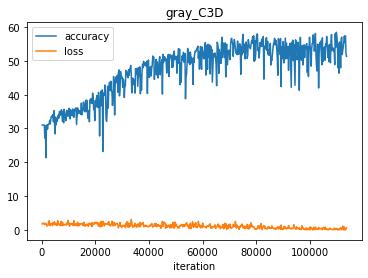

In [33]:
loss_accuracy_graph(nome_modello,torch.load(nome_modello+'.pth')) #su cpu aggiungere <,map_location="cpu">

In [34]:
print_test(gray_y_test,gray_y_pred)

              precision    recall  f1-score   support

       block       0.28      0.63      0.38       292
        pass       0.33      0.10      0.15       318
         run       0.66      0.62      0.64      1841
     dribble       0.55      0.51      0.53      1068
       shoot       0.50      0.26      0.34       125
ball in hand       0.44      0.30      0.36       709
     defense       0.31      0.79      0.45      1178
        pick       0.16      0.27      0.20       228
   no_action       0.66      0.60      0.63      1916
        walk       0.74      0.42      0.54      3451

    accuracy                           0.52     11126
   macro avg       0.46      0.45      0.42     11126
weighted avg       0.59      0.52      0.52     11126

[[ 183    2   13    5    6    6   62    4    3    8]
 [  25   32   38   32    4   71   74   15   10   17]
 [  62    7 1141  246    3   31  200   36    0  115]
 [  14   15  147  550    3   58  178   42    9   52]
 [  52    6    1    0   32   

## Test Low Res C3D con freezed layers

In [23]:
nome_modello = 'freezed_lr_C3D'

In [30]:
freezed_lr_y_test, freezed_lr_y_pred = test (model,lr_test_loader,load=True)

11126 video analizzati in 161.25360918045044 secondi: 1103.9504846108073 FPS


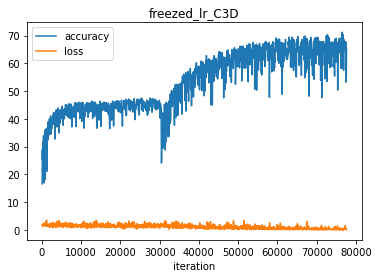

In [31]:
loss_accuracy_graph(nome_modello,torch.load(nome_modello+'.pth')) #su cpu aggiungere <,map_location="cpu">

In [32]:
print_test(freezed_lr_y_test,freezed_lr_y_pred)

              precision    recall  f1-score   support

       block       0.41      0.71      0.52       292
        pass       0.49      0.22      0.31       318
         run       0.67      0.86      0.75      1841
     dribble       0.84      0.70      0.76      1068
       shoot       0.54      0.39      0.46       125
ball in hand       0.60      0.62      0.61       709
     defense       0.55      0.75      0.64      1178
        pick       0.42      0.31      0.35       228
   no_action       0.71      0.66      0.68      1916
        walk       0.77      0.63      0.69      3451

    accuracy                           0.67     11126
   macro avg       0.60      0.59      0.58     11126
weighted avg       0.69      0.67      0.67     11126

[[ 208    1   22    2    6    2   32    3    6   10]
 [  29   71   28   28   12   89   14    7   17   23]
 [  14    3 1587   46    2   22   47    4    0  116]
 [   2   22  170  749    1   64   35    3    4   18]
 [  45    8    3    0   49   

## Test Low Res C3D

In [25]:
lr_y_test, lr_y_pred = test (model,lr_test_loader,load=True)

11126 video analizzati in 184.93988156318665 secondi: 962.5614469704252 FPS


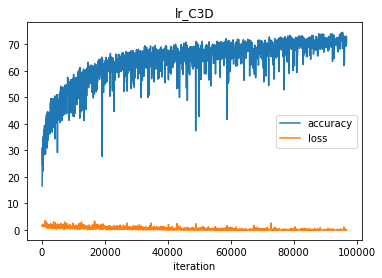

In [26]:
loss_accuracy_graph(nome_modello,torch.load(nome_modello+'.pth')) #su cpu aggiungere <,map_location="cpu">

In [27]:
print_test(lr_y_test,lr_y_pred)

              precision    recall  f1-score   support

       block       0.96      0.08      0.15       292
        pass       0.54      0.41      0.46       318
         run       0.92      0.64      0.75      1841
     dribble       0.71      0.88      0.79      1068
       shoot       0.70      0.41      0.52       125
ball in hand       0.73      0.58      0.65       709
     defense       0.82      0.56      0.67      1178
        pick       0.54      0.42      0.47       228
   no_action       0.62      0.79      0.69      1916
        walk       0.68      0.83      0.75      3451

    accuracy                           0.71     11126
   macro avg       0.72      0.56      0.59     11126
weighted avg       0.73      0.71      0.70     11126

[[  24   10    4    6   14   22   14   15   88   95]
 [   0  129    6   51    1   35    4    3   40   49]
 [   0    8 1174  180    0    8   15    3   10  443]
 [   0   13   24  940    0   34   11    1    7   38]
 [   0   21    0    2   51   

## Mini-Train-test

In [ ]:
train (model, mini_train_loader,mini_test_loader,optimizer,error, test_every=test_every, print_every=print_every, save_every=save_every , num_epochs=num_epochs)

In [20]:
mini_y_test, mini_y_pred = test (model,mini_test_loader,load=True)

500 video analizzati in 19.36237668991089 secondi: 413.17241824804194 FPS


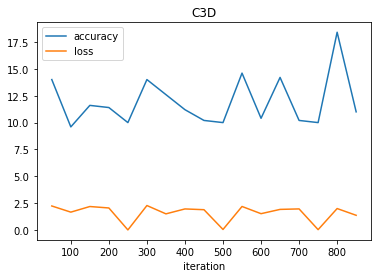

In [21]:
loss_accuracy_graph(nome_modello,torch.load(nome_modello+'.pth')) #su cpu aggiungere <,map_location="cpu">

In [137]:
print_test(mini_y_test,mini_y_pred)

              precision    recall  f1-score   support

       block       0.00      0.00      0.00        50
        pass       0.00      0.00      0.00        50
         run       0.00      0.00      0.00        50
     dribble       0.00      0.00      0.00        50
       shoot       0.10      1.00      0.18        50
ball in hand       0.00      0.00      0.00        50
     defense       0.00      0.00      0.00        50
        pick       0.00      0.00      0.00        50
   no_action       0.00      0.00      0.00        50
        walk       0.00      0.00      0.00        50

    accuracy                           0.10       500
   macro avg       0.01      0.10      0.02       500
weighted avg       0.01      0.10      0.02       500

[[ 0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0

## Mini-gray-train-test

In [130]:
train (model, mini_gray_train_loader,mini_gray_test_loader,optimizer,error, test_every=test_every, print_every=print_every, save_every=save_every , num_epochs=num_epochs)

Epoch: 0	 | Iteration: 50	 | Loss: 2.29873	 | Accuracy: 9.80%
Epoch: 0	 | Iteration: 100	 | Loss: 2.30553	 | Accuracy: 9.60%
Epoch: 1	 | Iteration: 150	 | Loss: 2.30078	 | Accuracy: 12.60%
Epoch: 1	 | Iteration: 200	 | Loss: 2.29991	 | Accuracy: 10.80%
Epoch: 1	 | Iteration: 250	 | Loss: 2.30961	 | Accuracy: 8.20%
Epoch: 2	 | Iteration: 300	 | Loss: 2.29934	 | Accuracy: 10.20%
Epoch: 2	 | Iteration: 350	 | Loss: 2.31008	 | Accuracy: 8.20%
Epoch: 3	 | Iteration: 400	 | Loss: 2.29919	 | Accuracy: 9.60%
Epoch: 3	 | Iteration: 450	 | Loss: 2.29825	 | Accuracy: 11.20%
Epoch: 3	 | Iteration: 500	 | Loss: 2.31309	 | Accuracy: 10.40%
Epoch: 4	 | Iteration: 550	 | Loss: 2.29819	 | Accuracy: 11.80%
Epoch: 4	 | Iteration: 600	 | Loss: 2.31061	 | Accuracy: 8.80%
Epoch: 5	 | Iteration: 650	 | Loss: 2.29986	 | Accuracy: 9.00%
Epoch: 5	 | Iteration: 700	 | Loss: 2.29908	 | Accuracy: 10.00%
Epoch: 5	 | Iteration: 750	 | Loss: 2.31040	 | Accuracy: 11.20%
Epoch: 6	 | Iteration: 800	 | Loss: 2.29970	 | A

In [131]:
mini_gray_y_test, mini_gray_y_pred = test (model,mini_gray_test_loader,load=True)

500 video analizzati in 4.39824366569519 secondi: 1818.9078659732493 FPS


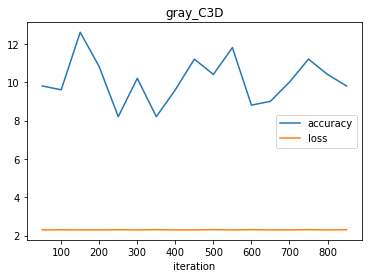

In [132]:
loss_accuracy_graph(nome_modello,torch.load(nome_modello+'.pth')) #su cpu aggiungere <,map_location="cpu">

In [138]:
print_test(mini_gray_y_test,mini_gray_y_pred)

              precision    recall  f1-score   support

       block       0.00      0.00      0.00        50
        pass       0.00      0.00      0.00        50
         run       0.00      0.00      0.00        50
     dribble       0.00      0.00      0.00        50
       shoot       0.00      0.00      0.00        50
ball in hand       0.00      0.00      0.00        50
     defense       0.00      0.00      0.00        50
        pick       0.00      0.00      0.00        50
   no_action       0.00      0.00      0.00        50
        walk       0.10      1.00      0.18        50

    accuracy                           0.10       500
   macro avg       0.01      0.10      0.02       500
weighted avg       0.01      0.10      0.02       500

[[ 0  0  0  0  0  0  0  0  0 50]
 [ 0  0  0  0  0  0  0  0  0 50]
 [ 0  0  0  0  0  0  0  0  0 50]
 [ 0  0  0  0  0  0  0  0  0 50]
 [ 0  0  0  0  0  0  0  0  0 50]
 [ 0  0  0  0  0  0  0  0  0 50]
 [ 0  0  0  0  0  0  0  0  0 50]
 [ 0  0  0

## Conclusioni
A valle dell'analisi del responso dei vari modelli sul testset, è stato scelto il modello lr_C3D, che ha raggiunto i risultati migliori nel minor tempo.

# Test suite

### Import

In [1]:
SEED = 9126

import os
import json
import time
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import cv2

from PIL import Image
import pandas as pd
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import Video

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

transform= torchvision.transforms.ToTensor()

USE_CUDA = True
CUDA = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")

if CUDA:
    print('run on %s' % device)

run on cuda


### Caricamento dei dizionari

In [2]:
DATASET_DIR = 'dataset'
DATASET_FILES = 'dataset/examples'
KEYSET_FILE = 'testset_keys_1lug2020.txt'

labels_dict = {0 : "block", 1 : "pass", 2 : "run", 3: "dribble",4: "shoot",
          5 : "ball in hand", 6 : "defense", 7: "pick" , 8 : "no_action" , 
          9: "walk"}

with open(os.path.join(DATASET_DIR, 'annotation_dict.json')) as fp:
    annotations = json.load(fp)    

In [3]:
with open(KEYSET_FILE) as fp:
    keys_test = json.load(fp)

annotationTest = dict(filter(lambda x: x[0] in keys_test, annotations.items()));

Prepariamo la lista di id del test set

In [4]:
def annotations2idlist(annotations):
    lista = []
    for i in annotations.keys():
        lista.append(i)
    return sorted(lista)
id_test = annotations2idlist(annotationTest)

### Definizione del loader per il testset

#### Loader low res

In [5]:
scale_percent=35
def lr_loader(path):
    framesDelVideo = []
    
    video = cv2.VideoCapture(path)
    while True:
        # Capture frame-by-frame
        ret, frame = video.read()
        if ret:

            width = int(frame.shape[1] * scale_percent / 100)
            height = int(frame.shape[0] * scale_percent / 100)
            dim = (width, height)
            frame = cv2.resize(frame,dim,interpolation = cv2.INTER_AREA)
            
            frame = transform(Image.fromarray(frame))
            framesDelVideo.append(frame.unsqueeze(0))
        else:
            break
            
    return torch.transpose(torch.cat(framesDelVideo, axis=0),0,1)

class lr_dataset(torch.utils.data.Dataset):
    def __init__(self,root, list_IDs, labels):
        self.labels = labels
        self.list_IDs = list_IDs
        self.root=root

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = lr_loader(os.path.join(self.root,ID+'.mp4'))
        y = self.labels[ID]

        return X, y
    
    
def lr_load_dataset(root,list_IDs,labels):
    dataset = lr_dataset(root,list_IDs,labels)
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=8,
        num_workers=0,
        shuffle=False
    )
    return loader
lr_test_loader = lr_load_dataset('./dataset/examples',id_test,annotationTest)

## Il modello

In [6]:
class lr_C3D(nn.Module):

    def __init__(self, num_classes):
        super(lr_C3D, self).__init__()

        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3a = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv3b = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4a = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv4b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv5a = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv5b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 1, 1))

        self.fc6 = nn.Linear(2048, 7680)
        self.fc7 = nn.Linear(7680, 7680)
        self.fc8 = nn.Linear(7680, num_classes)

        self.dropout = nn.Dropout(p=0.5)

        self.relu = nn.ReLU()


    def forward(self, x):
        
        x = self.relu(self.conv1(x))
        x = self.pool1(x)

        x = self.relu(self.conv2(x))
        x = self.pool2(x)

        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool3(x)

        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        x = self.pool4(x)

        x = self.relu(self.conv5a(x))
        x = self.relu(self.conv5b(x))
        x = self.pool5(x)
        
        x = x.view(-1, 2048)
        x = self.relu(self.fc6(x))
        x = self.dropout(x)
        x = self.relu(self.fc7(x))
        x = self.dropout(x)

        logits = self.fc8(x)
        
        return logits
nome_modello = "lr_C3D" #se non funziona sulla versione di cuda settare nome_modello = "lr_C3D_reduced"
model = lr_C3D(10).to(device)
lr_C3D(10)

lr_C3D(
  (conv1): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3b): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv4b): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool4): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv5a): Conv3d(512, 512, kernel_size=(3, 3, 3), stri

## Testing del modello

In [7]:
def test (model,test_loader,load=False):        
    if load:
        checkpoint = torch.load(nome_modello+'.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    y_test =[]
    y_pred= []
    correct = 0
    total = 0
    
    start = time.time()
    # Iterate through test dataset
    for idx, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device),labels.to(device)
        # Forward propagation
        outputs = model(images)

        # Get predictions from the maximum value
        predicted = torch.max(outputs.data, 1)[1]
        y_test.extend(labels)
        y_pred.extend(predicted)
        # Total number of labels
        total += len(labels)
        correct += (predicted == labels).sum()
    
    end = time.time()
    print(f'{len(test_loader.dataset)} video analizzati in {end - start} secondi: {len(test_loader.dataset)*16/(end - start)} FPS')
    
    y_test_list = [i.item() for i in y_test]
    y_pred_list = [i.item() for i in y_pred]
    return y_test_list, y_pred_list

In [8]:
def print_test(y_test, y_pred):
    print(classification_report(y_test,y_pred,zero_division=0,target_names=labels_dict.values()))
    print(confusion_matrix(y_test,y_pred))

In [9]:
def loss_accuracy_graph(nome_modello, checkpoint):
    x = checkpoint['iteration_list']
    y1 = checkpoint['accuracy_list']
    y2 = checkpoint['loss_list']

    plt.plot(x, y1, label = "accuracy")

    plt.plot(x, y2, label = "loss")

    plt.xlabel('iteration')
    # Set a title of the current axes.
    plt.title(nome_modello)
    # show a legend on the plot
    plt.legend()
    # Display a figure.
    plt.show()

## Test Low Res C3D

In [10]:
lr_y_test, lr_y_pred = test (model,lr_test_loader,load=True)

11126 video analizzati in 190.60960483551025 secondi: 933.9298518226396 FPS


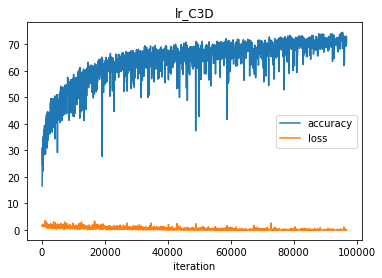

In [11]:
loss_accuracy_graph(nome_modello,torch.load(nome_modello+'.pth')) #su cpu aggiungere <,map_location="cpu">

In [12]:
print_test(lr_y_test,lr_y_pred)

              precision    recall  f1-score   support

       block       0.96      0.08      0.15       292
        pass       0.54      0.41      0.46       318
         run       0.92      0.64      0.75      1841
     dribble       0.71      0.88      0.79      1068
       shoot       0.70      0.41      0.52       125
ball in hand       0.73      0.58      0.65       709
     defense       0.82      0.56      0.67      1178
        pick       0.54      0.42      0.47       228
   no_action       0.62      0.79      0.69      1916
        walk       0.68      0.83      0.75      3451

    accuracy                           0.71     11126
   macro avg       0.72      0.56      0.59     11126
weighted avg       0.73      0.71      0.70     11126

[[  24   10    4    6   14   22   14   15   88   95]
 [   0  129    6   51    1   35    4    3   40   49]
 [   0    8 1174  180    0    8   15    3   10  443]
 [   0   13   24  940    0   34   11    1    7   38]
 [   0   21    0    2   51   